# Imports

In [1]:
import copy
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
seed=0
import random
random.seed(seed)
import torch
import pickle

In [57]:
df = pd.read_csv('PREPROCEDED_DATA/data_project_nel_final.csv')
df_target = pd.read_csv('PREPROCEDED_DATA\y_lactose.csv')

df.head()

,lactation,delivery_age_years,dim,forage_kg_day,rumination_min_day,milk_kg_day,milk_kg_min_robot,milkings_day,errors_by_100_milkings,high_cdt_by_100_milkings,watery_by_100_milkings,refusals_by_milking,colostrum_separated_kg
0,2.5,2.727273,2.000000,-0.520602,-1.363097,-0.585971,0.758114,-0.536556,0.880849,0.0,0.000000,-0.419046,-0.287129
1,3.0,3.454545,0.865672,-0.727744,0.683673,-0.360530,1.032366,-0.886595,0.079645,0.0,0.000000,-0.662570,-0.287129
2,2.0,2.681818,0.029851,0.332580,0.062809,0.416761,-0.060509,-0.642058,0.193565,0.0,0.132979,-0.544060,0.346535
3,2.5,3.227273,0.965174,-0.543924,1.198016,0.234487,-0.045447,-0.866993,0.682583,0.0,0.000000,-0.481095,0.514851
4,1.5,2.045455,2.258706,0.181772,-0.774017,-0.172111,-0.750715,0.234290,-0.029252,0.0,0.000000,0.981003,0.712871


In [59]:
X_train, X_test, y_train, y_test = train_test_split(df,df_target, test_size = 0.3, 
                                                  random_state = seed,
                                                  shuffle = True)

In [60]:
torch.manual_seed(seed)

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

print("Training data shape:", X_train.shape, y_train.shape)
print("Test data shape:", X_test.shape, y_test.shape)

Training data shape: torch.Size([226, 12]) torch.Size([226, 1])
Test data shape: torch.Size([98, 12]) torch.Size([98, 1])


# SIMPLE CUSTOM NN

In [71]:
# Neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleNN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        return x

# Training function
def train_model(model, optimizer, criterion, train_loader, val_loader=None, n_epochs=100):
    train_rmse_list = []
    val_rmse_list = []

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        
        train_rmse = np.sqrt(train_loss / len(train_loader.dataset))
        train_rmse_list.append(train_rmse)

        if val_loader is not None:
            model.eval()  # Set model to evaluation mode
            val_loss = 0.0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item() * inputs.size(0)
            
            val_rmse = np.sqrt(val_loss / len(val_loader.dataset))
            val_rmse_list.append(val_rmse)

    return train_rmse_list, val_rmse_list

# Hyperparameter search function
def hyperparameter_search(X_train, y_train, hidden_sizes, learning_rates, optimizers, n_folds=5):
    best_score = float('inf')
    best_params = None

    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    for hidden_size in hidden_sizes:
        for lr in learning_rates:
            for optimizer_name in optimizers:
                fold_scores = []
                for train_index, val_index in kf.split(X_train):                    
                    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
                    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

                    train_dataset = torch.utils.data.TensorDataset(X_train_fold, y_train_fold)
                    val_dataset = torch.utils.data.TensorDataset(X_val_fold, y_val_fold)

                    # Use DataLoader to handle batching and shuffling
                    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
                    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

                    model = SimpleNN(input_size=X_train.shape[1], hidden_size=hidden_size)
                    criterion = nn.MSELoss()
                    if optimizer_name == 'SGD':
                        optimizer = optim.SGD(model.parameters(), lr=lr)
                    elif optimizer_name == 'Adam':
                        optimizer = optim.Adam(model.parameters(), lr=lr)
                    elif optimizer_name == 'Adadelta':
                        optimizer = optim.Adadelta(model.parameters(), lr=lr)
                    elif optimizer_name == 'ASGD':
                        optimizer = optim.ASGD(model.parameters(), lr=lr)
                    elif optimizer_name == 'RMSprop':
                        optimizer = optim.RMSprop(model.parameters(), lr=lr)

                    train_rmse_list, val_rmse_list = train_model(model, optimizer, criterion, train_loader, val_loader, n_epochs=100)
                    fold_scores.append(val_rmse_list[-1])

                avg_score = np.mean(fold_scores)
                if avg_score < best_score:
                    best_score = avg_score
                    best_params = {
                        'hidden_size': hidden_size,
                        'learning_rate': lr,
                        'optimizer': optimizer_name,
                        'train_rmse_list': train_rmse_list,
                        'val_rmse_list': val_rmse_list
                    }

    return best_params, best_score, val_loader

# Plotting function
def plot_rmse(train_rmse_list, val_rmse_list, best_params):
    plt.figure(figsize=(10, 5))
    plt.plot(train_rmse_list, label='Training RMSE')
    plt.plot(val_rmse_list, label='Validation RMSE')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.title(f'Best Model: Hidden Size={best_params["hidden_size"]}, LR={best_params["learning_rate"]}, Optimizer={best_params["optimizer"]}')
    plt.legend()
    plt.show()

In [72]:
# Main pipeline
hidden_sizes = [2, 4, 8, 16, 32, 64]
learning_rates = [0.0001, 0.001, 0.01, 0.1]
optimizers = ['SGD', 'Adam', 'Adadelta', 'ASGD', 'RMSprop']

best_params, best_score, val_loader = hyperparameter_search(X_train, y_train, hidden_sizes, learning_rates, optimizers)

print(f'Best Hyperparameters: {best_params}')
print(f'Best RMSE Score: {best_score}')

Best Hyperparameters: {'hidden_size': 4, 'learning_rate': 0.1, 'optimizer': 'ASGD', 'train_rmse_list': [3.1620263644399826, 0.7187364108143199, 0.3363425473629918, 0.20932091444509807, 0.15759632256740966, 0.13199763314031335, 0.11505451245619817, 0.10724730072611065, 0.09872884182786353, 0.09227294914179689, 0.08854105724404292, 0.08446506178233519, 0.0815244373079087, 0.07876861869662835, 0.07667012404409697, 0.07616707447522084, 0.07305933020262982, 0.0717469745172249, 0.07137789309543748, 0.06984201055264147, 0.06858614511920678, 0.0674681053539873, 0.06694180686063525, 0.06701844013084016, 0.06509656336594129, 0.06579696709069398, 0.06460654390603462, 0.06403398083562059, 0.06356740377710586, 0.06377673695846184, 0.06287080064284616, 0.0628100834056651, 0.06214089356052314, 0.06190050268486703, 0.06164809710309294, 0.06142859268412333, 0.061417080926713864, 0.06107477541917224, 0.06080475747538003, 0.06046244359994285, 0.060659105418117705, 0.06063141267132346, 0.06046097833572718

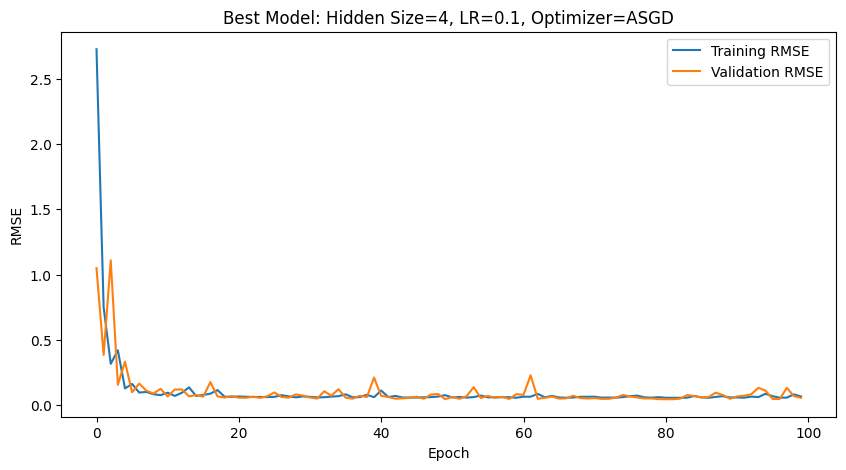

In [73]:
# Train final model with best hyperparameters
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

model = SimpleNN(input_size=X_train.shape[1], hidden_size=best_params['hidden_size'])
criterion = nn.MSELoss()
if best_params['optimizer'] == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=best_params['learning_rate'])
elif best_params['optimizer'] == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])
elif best_params['optimizer'] == 'Adadelta':
    optimizer = optim.Adadelta(model.parameters(), lr=best_params['learning_rate'])
elif best_params['optimizer'] == 'ASGD':
    optimizer = optim.ASGD(model.parameters(), lr=best_params['learning_rate'])
elif best_params['optimizer'] == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(), lr=best_params['learning_rate'])

train_rmse_list, val_rmse_list = train_model(model, optimizer, criterion, train_loader, val_loader, n_epochs=100)
plot_rmse(train_rmse_list, val_rmse_list, best_params)

In [74]:
# Evaluate on test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_rmse = np.sqrt(test_loss.item())

print(f'Test RMSE: {test_rmse}')

Test RMSE: 0.06963037045238073


# COMPLEX NN FOR 100 EPOCHS

In [75]:
class ComplexNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, dropout_prob=0.5):
        super(ComplexNN, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_size1)
        self.hidden2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
        self.output = nn.Linear(hidden_size2, 1)
    
    def forward(self, x):
        x = self.hidden1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.hidden2(x)
        x = self.relu(x)
        x = self.output(x)
        return x

# Training function
def train_model(model, optimizer, criterion, train_loader, val_loader=None, n_epochs=100):
    train_rmse_list = []
    val_rmse_list = []

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        
        train_rmse = np.sqrt(train_loss / len(train_loader.dataset))
        train_rmse_list.append(train_rmse)

        if val_loader is not None:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item() * inputs.size(0)
            
            val_rmse = np.sqrt(val_loss / len(val_loader.dataset))
            val_rmse_list.append(val_rmse)

        else:
            val_rmse_list.append(float('nan'))

    return train_rmse_list, val_rmse_list


# Hyperparameter search function
def hyperparameter_search(X_train, y_train, hidden_sizes, learning_rates, optimizers, n_folds=5):
    best_score = float('inf')
    best_params = None

    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    for hidden_size1 in hidden_sizes:
        for hidden_size2 in hidden_sizes:
            for lr in learning_rates:
                for optimizer_name in optimizers:
                    fold_scores = []
                    for train_index, val_index in kf.split(X_train):
                        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
                        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

                        train_dataset = torch.utils.data.TensorDataset(X_train_fold, y_train_fold)
                        val_dataset = torch.utils.data.TensorDataset(X_val_fold, y_val_fold)

                        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
                        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

                        model = ComplexNN(input_size=X_train.shape[1], hidden_size1=hidden_size1, hidden_size2=hidden_size2)
                        criterion = nn.MSELoss()
                        if optimizer_name == 'SGD':
                            optimizer = optim.SGD(model.parameters(), lr=lr)
                        elif optimizer_name == 'Adam':
                            optimizer = optim.Adam(model.parameters(), lr=lr)
                        elif optimizer_name == 'Adadelta':
                            optimizer = optim.Adadelta(model.parameters(), lr=lr)
                        elif optimizer_name == 'ASGD':
                            optimizer = optim.ASGD(model.parameters(), lr=lr)
                        elif optimizer_name == 'RMSprop':
                            optimizer = optim.RMSprop(model.parameters(), lr=lr)

                        train_rmse_list, val_rmse_list = train_model(model, optimizer, criterion, train_loader, val_loader, n_epochs=100)
                        fold_scores.append(val_rmse_list[-1])

                    avg_score = np.mean(fold_scores)
                    if avg_score < best_score:
                        best_score = avg_score
                        best_params = {
                            'hidden_size1': hidden_size1,
                            'hidden_size2': hidden_size2,
                            'learning_rate': lr,
                            'optimizer': optimizer_name,
                            'train_rmse_list': train_rmse_list,
                            'val_rmse_list': val_rmse_list
                        }

    return best_params, best_score, val_loader

# Plotting function
def plot_rmse(train_rmse_list, val_rmse_list, best_params):
    plt.figure(figsize=(10, 5))
    plt.plot(train_rmse_list, label='Training RMSE')
    plt.plot(val_rmse_list, label='Validation RMSE')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.title(f'Best Model: Hidden Size1={best_params["hidden_size1"]}, Hidden Size2={best_params["hidden_size2"]}, LR={best_params["learning_rate"]}, Optimizer={best_params["optimizer"]}')
    plt.legend()
    plt.show()

In [76]:
# Main Pipeline
hidden_sizes = [16, 32, 64, 128]
learning_rates = [0.0001, 0.001, 0.01, 0.1]
optimizers = ['SGD', 'Adam', 'Adadelta', 'ASGD', 'RMSprop']

best_params, best_score, val_loader = hyperparameter_search(X_train, y_train, hidden_sizes, learning_rates, optimizers)

print(f'Best Hyperparameters: {best_params}')
print(f'Best RMSE Score: {best_score}')

Best Hyperparameters: {'hidden_size1': 128, 'hidden_size2': 32, 'learning_rate': 0.1, 'optimizer': 'ASGD', 'train_rmse_list': [3.7134995362804446, 0.5829819174391901, 0.5324643847526778, 0.35022085690446836, 0.33222887116929883, 0.2905596531246888, 0.2918174276501805, 0.25527074902462277, 0.22751094273591133, 0.1946660748765271, 0.19827657332378595, 0.1538854239673967, 0.16431193692265592, 0.17143999437070964, 0.1619559295133654, 0.1648077803142701, 0.1167171063948202, 0.11867529079507519, 0.12748147288577127, 0.12953057511379992, 0.11186905173105573, 0.09681229912931165, 0.1008349375330571, 0.09670410572229872, 0.10143440385623476, 0.09118466174793327, 0.0933197970482709, 0.08580819243605643, 0.09610932235214725, 0.08703667838406177, 0.09644054533544884, 0.08043629038375871, 0.07806736840051617, 0.09041223114324431, 0.07444732749720481, 0.0788404195898678, 0.07316255291133311, 0.0771098694109676, 0.08058796451617103, 0.08188001152277703, 0.07367697836907906, 0.07160257323471933, 0.078

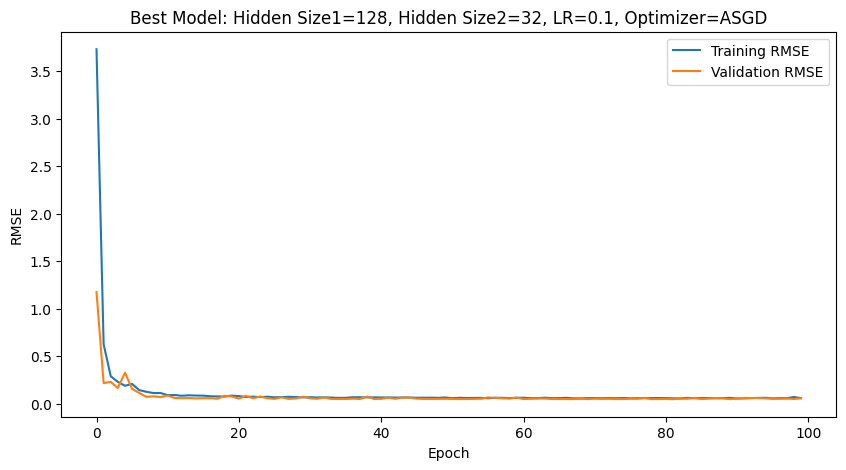

In [77]:
# Train final model with best hyperparameters and VAL_LOADER
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

model = ComplexNN(input_size=X_train.shape[1], hidden_size1=best_params['hidden_size1'], hidden_size2=best_params['hidden_size2'])
criterion = nn.MSELoss()
if best_params['optimizer'] == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=best_params['learning_rate'])
elif best_params['optimizer'] == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])
elif best_params['optimizer'] == 'Adadelta':
    optimizer = optim.Adadelta(model.parameters(), lr=best_params['learning_rate'])
elif best_params['optimizer'] == 'ASGD':
    optimizer = optim.ASGD(model.parameters(), lr=best_params['learning_rate'])
elif best_params['optimizer'] == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(), lr=best_params['learning_rate'])

train_rmse_list, val_rmse_list = train_model(model, optimizer, criterion, train_loader, val_loader, n_epochs=100)
plot_rmse(train_rmse_list, val_rmse_list, best_params)

In [78]:
# Evaluate on test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_rmse = np.sqrt(test_loss.item())

print(f'Test RMSE: {test_rmse}')

Test RMSE: 0.08207379384580138


# SIMPLE NN FOR 200 EPOCHS

In [87]:
# Neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleNN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        return x

# Training function
def train_model(model, optimizer, criterion, train_loader, val_loader=None, n_epochs=200):
    train_rmse_list = []
    val_rmse_list = []

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        
        train_rmse = np.sqrt(train_loss / len(train_loader.dataset))
        train_rmse_list.append(train_rmse)

        if val_loader is not None:
            model.eval()  # Set model to evaluation mode
            val_loss = 0.0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item() * inputs.size(0)
            
            val_rmse = np.sqrt(val_loss / len(val_loader.dataset))
            val_rmse_list.append(val_rmse)

    return train_rmse_list, val_rmse_list

# Hyperparameter search function
def hyperparameter_search(X_train, y_train, hidden_sizes, learning_rates, optimizers, n_folds=5):
    best_score = float('inf')
    best_params = None

    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    for hidden_size in hidden_sizes:
        for lr in learning_rates:
            for optimizer_name in optimizers:
                fold_scores = []
                for train_index, val_index in kf.split(X_train):                    
                    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
                    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

                    train_dataset = torch.utils.data.TensorDataset(X_train_fold, y_train_fold)
                    val_dataset = torch.utils.data.TensorDataset(X_val_fold, y_val_fold)

                    # Use DataLoader to handle batching and shuffling
                    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
                    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

                    model = SimpleNN(input_size=X_train.shape[1], hidden_size=hidden_size)
                    criterion = nn.MSELoss()
                    if optimizer_name == 'SGD':
                        optimizer = optim.SGD(model.parameters(), lr=lr)
                    elif optimizer_name == 'Adam':
                        optimizer = optim.Adam(model.parameters(), lr=lr)
                    elif optimizer_name == 'Adadelta':
                        optimizer = optim.Adadelta(model.parameters(), lr=lr)
                    elif optimizer_name == 'ASGD':
                        optimizer = optim.ASGD(model.parameters(), lr=lr)
                    elif optimizer_name == 'RMSprop':
                        optimizer = optim.RMSprop(model.parameters(), lr=lr)

                    train_rmse_list, val_rmse_list = train_model(model, optimizer, criterion, train_loader, val_loader, n_epochs=100)
                    fold_scores.append(val_rmse_list[-1])

                avg_score = np.mean(fold_scores)
                if avg_score < best_score:
                    best_score = avg_score
                    best_params = {
                        'hidden_size': hidden_size,
                        'learning_rate': lr,
                        'optimizer': optimizer_name,
                        'train_rmse_list': train_rmse_list,
                        'val_rmse_list': val_rmse_list
                    }

    return best_params, best_score, val_loader

# Plotting function
def plot_rmse(train_rmse_list, val_rmse_list, best_params):
    plt.figure(figsize=(10, 5))
    plt.plot(train_rmse_list, label='Training RMSE')
    plt.plot(val_rmse_list, label='Validation RMSE')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.title(f'Best Model: Hidden Size={best_params["hidden_size"]}, LR={best_params["learning_rate"]}, Optimizer={best_params["optimizer"]}')
    plt.legend()
    plt.show()

In [88]:
# Main pipeline
hidden_sizes = [2, 4, 8, 16, 32, 64]
learning_rates = [0.0001, 0.001, 0.01, 0.1]
optimizers = ['SGD', 'Adam', 'Adadelta', 'ASGD', 'RMSprop']

best_params, best_score, val_loader = hyperparameter_search(X_train, y_train, hidden_sizes, learning_rates, optimizers)

print(f'Best Hyperparameters: {best_params}')
print(f'Best RMSE Score: {best_score}')

Best Hyperparameters: {'hidden_size': 2, 'learning_rate': 0.1, 'optimizer': 'SGD', 'train_rmse_list': [2.8973859142272995, 0.8865886902671388, 0.5262258021864216, 0.3470095620113817, 0.2629814715336033, 0.2114239814380599, 0.18131946754836187, 0.15514784460785921, 0.13179084446900735, 0.11999459104486453, 0.11279816323697918, 0.10684410013924427, 0.10206255088228214, 0.09746673003006844, 0.09468175952172292, 0.09080038871646336, 0.08816774024686129, 0.08584437131808585, 0.08443540279403702, 0.08185548532661302, 0.08032426437811935, 0.07810930038676413, 0.07639033812491577, 0.075280964839186, 0.07408756139688502, 0.07317996601441824, 0.07233963093806556, 0.07101965402008899, 0.07054625020824959, 0.06950569484501654, 0.06869315612951257, 0.06813274770953646, 0.06749005356940124, 0.06736532181005365, 0.06675254592373671, 0.06579362541205053, 0.06584221641068816, 0.06538254426382896, 0.06473442177003431, 0.06441316915083053, 0.06481920706219609, 0.06438532373696457, 0.06356266078148042, 0.

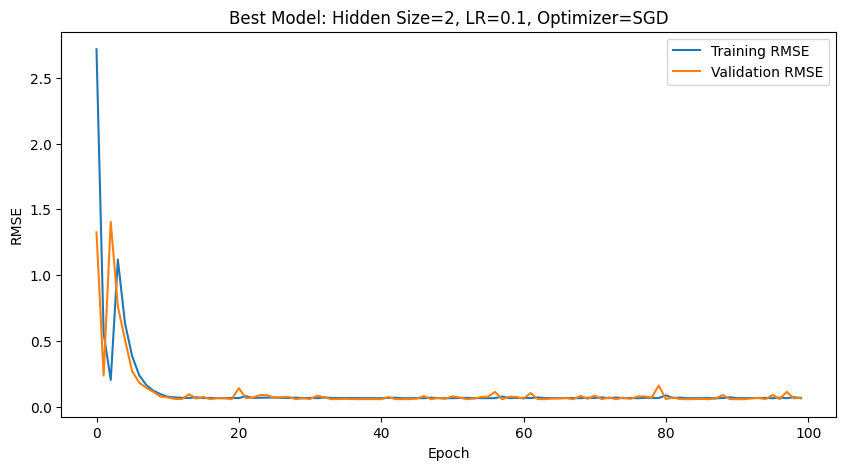

In [89]:
# Train final model with best hyperparameters
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

model = SimpleNN(input_size=X_train.shape[1], hidden_size=best_params['hidden_size'])
criterion = nn.MSELoss()
if best_params['optimizer'] == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=best_params['learning_rate'])
elif best_params['optimizer'] == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])
elif best_params['optimizer'] == 'Adadelta':
    optimizer = optim.Adadelta(model.parameters(), lr=best_params['learning_rate'])
elif best_params['optimizer'] == 'ASGD':
    optimizer = optim.ASGD(model.parameters(), lr=best_params['learning_rate'])
elif best_params['optimizer'] == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(), lr=best_params['learning_rate'])

train_rmse_list, val_rmse_list = train_model(model, optimizer, criterion, train_loader, val_loader, n_epochs=100)
plot_rmse(train_rmse_list, val_rmse_list, best_params)

In [90]:
# Evaluate on test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_rmse = np.sqrt(test_loss.item())

print(f'Test RMSE: {test_rmse}')

Test RMSE: 0.08504135885717173


# SIMPLE NN FOR 500 EPOCHS

In [91]:
# Neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleNN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        return x

# Training function
def train_model(model, optimizer, criterion, train_loader, val_loader=None, n_epochs=500):
    train_rmse_list = []
    val_rmse_list = []

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        
        train_rmse = np.sqrt(train_loss / len(train_loader.dataset))
        train_rmse_list.append(train_rmse)

        if val_loader is not None:
            model.eval()  # Set model to evaluation mode
            val_loss = 0.0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item() * inputs.size(0)
            
            val_rmse = np.sqrt(val_loss / len(val_loader.dataset))
            val_rmse_list.append(val_rmse)

    return train_rmse_list, val_rmse_list

# Hyperparameter search function
def hyperparameter_search(X_train, y_train, hidden_sizes, learning_rates, optimizers, n_folds=5):
    best_score = float('inf')
    best_params = None

    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    for hidden_size in hidden_sizes:
        for lr in learning_rates:
            for optimizer_name in optimizers:
                fold_scores = []
                for train_index, val_index in kf.split(X_train):                    
                    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
                    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

                    train_dataset = torch.utils.data.TensorDataset(X_train_fold, y_train_fold)
                    val_dataset = torch.utils.data.TensorDataset(X_val_fold, y_val_fold)

                    # Use DataLoader to handle batching and shuffling
                    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
                    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

                    model = SimpleNN(input_size=X_train.shape[1], hidden_size=hidden_size)
                    criterion = nn.MSELoss()
                    if optimizer_name == 'SGD':
                        optimizer = optim.SGD(model.parameters(), lr=lr)
                    elif optimizer_name == 'Adam':
                        optimizer = optim.Adam(model.parameters(), lr=lr)
                    elif optimizer_name == 'Adadelta':
                        optimizer = optim.Adadelta(model.parameters(), lr=lr)
                    elif optimizer_name == 'ASGD':
                        optimizer = optim.ASGD(model.parameters(), lr=lr)
                    elif optimizer_name == 'RMSprop':
                        optimizer = optim.RMSprop(model.parameters(), lr=lr)

                    train_rmse_list, val_rmse_list = train_model(model, optimizer, criterion, train_loader, val_loader, n_epochs=100)
                    fold_scores.append(val_rmse_list[-1])

                avg_score = np.mean(fold_scores)
                if avg_score < best_score:
                    best_score = avg_score
                    best_params = {
                        'hidden_size': hidden_size,
                        'learning_rate': lr,
                        'optimizer': optimizer_name,
                        'train_rmse_list': train_rmse_list,
                        'val_rmse_list': val_rmse_list
                    }

    return best_params, best_score, val_loader

# Plotting function
def plot_rmse(train_rmse_list, val_rmse_list, best_params):
    plt.figure(figsize=(10, 5))
    plt.plot(train_rmse_list, label='Training RMSE')
    plt.plot(val_rmse_list, label='Validation RMSE')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.title(f'Best Model: Hidden Size={best_params["hidden_size"]}, LR={best_params["learning_rate"]}, Optimizer={best_params["optimizer"]}')
    plt.legend()
    plt.show()

In [92]:
# Main pipeline
hidden_sizes = [2, 4, 8, 16, 32, 64]
learning_rates = [0.0001, 0.001, 0.01, 0.1]
optimizers = ['SGD', 'Adam', 'Adadelta', 'ASGD', 'RMSprop']

best_params, best_score, val_loader = hyperparameter_search(X_train, y_train, hidden_sizes, learning_rates, optimizers)

print(f'Best Hyperparameters: {best_params}')
print(f'Best RMSE Score: {best_score}')

Best Hyperparameters: {'hidden_size': 2, 'learning_rate': 0.1, 'optimizer': 'Adam', 'train_rmse_list': [4.672624189638688, 3.2480454093594284, 2.709983527492047, 1.9349716194865636, 1.272072351275015, 0.9500418802848485, 0.6840354297044348, 0.5991009275447062, 0.4528792506675361, 0.3812099441855985, 0.31423112219211335, 0.25778298981074804, 0.22131858930189816, 0.17102095384602156, 0.14291444318450577, 0.12195114975218624, 0.10077808437259003, 0.08607194907969641, 0.07625564585048417, 0.06974742255537703, 0.0666414240203333, 0.06282912328053089, 0.06153294026490765, 0.0603042201491558, 0.059932715336862764, 0.05833227216645805, 0.058451239419452315, 0.059537240529777706, 0.059303082990876714, 0.05736027557844744, 0.057383018939546594, 0.05682184034990907, 0.057114482880415034, 0.05736830103074605, 0.056547281635145566, 0.05635260647587757, 0.05736769386332896, 0.05693691892769948, 0.05790352089447018, 0.057235996599843575, 0.05676075549004434, 0.05644271731730232, 0.05763763756831685, 

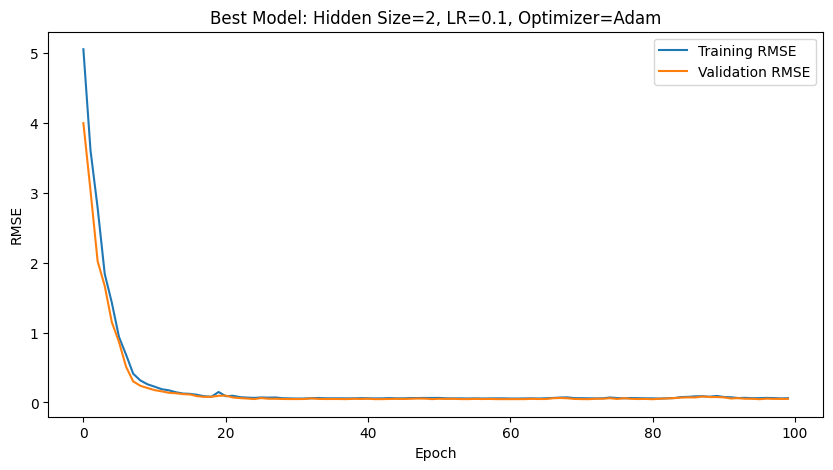

In [93]:
# Train final model with best hyperparameters
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

model = SimpleNN(input_size=X_train.shape[1], hidden_size=best_params['hidden_size'])
criterion = nn.MSELoss()
if best_params['optimizer'] == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=best_params['learning_rate'])
elif best_params['optimizer'] == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])
elif best_params['optimizer'] == 'Adadelta':
    optimizer = optim.Adadelta(model.parameters(), lr=best_params['learning_rate'])
elif best_params['optimizer'] == 'ASGD':
    optimizer = optim.ASGD(model.parameters(), lr=best_params['learning_rate'])
elif best_params['optimizer'] == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(), lr=best_params['learning_rate'])

train_rmse_list, val_rmse_list = train_model(model, optimizer, criterion, train_loader, val_loader, n_epochs=100)
plot_rmse(train_rmse_list, val_rmse_list, best_params)

In [94]:
# Evaluate on test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_rmse = np.sqrt(test_loss.item())

print(f'Test RMSE: {test_rmse}')

Test RMSE: 0.07066590188132908


# SIMPLE NN FOR 1000 EPOCHS

In [95]:
# Neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleNN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        return x

# Training function
def train_model(model, optimizer, criterion, train_loader, val_loader=None, n_epochs=1000):
    train_rmse_list = []
    val_rmse_list = []

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        
        train_rmse = np.sqrt(train_loss / len(train_loader.dataset))
        train_rmse_list.append(train_rmse)

        if val_loader is not None:
            model.eval()  # Set model to evaluation mode
            val_loss = 0.0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item() * inputs.size(0)
            
            val_rmse = np.sqrt(val_loss / len(val_loader.dataset))
            val_rmse_list.append(val_rmse)

    return train_rmse_list, val_rmse_list

# Hyperparameter search function
def hyperparameter_search(X_train, y_train, hidden_sizes, learning_rates, optimizers, n_folds=5):
    best_score = float('inf')
    best_params = None

    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    for hidden_size in hidden_sizes:
        for lr in learning_rates:
            for optimizer_name in optimizers:
                fold_scores = []
                for train_index, val_index in kf.split(X_train):                    
                    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
                    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

                    train_dataset = torch.utils.data.TensorDataset(X_train_fold, y_train_fold)
                    val_dataset = torch.utils.data.TensorDataset(X_val_fold, y_val_fold)

                    # Use DataLoader to handle batching and shuffling
                    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
                    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

                    model = SimpleNN(input_size=X_train.shape[1], hidden_size=hidden_size)
                    criterion = nn.MSELoss()
                    if optimizer_name == 'SGD':
                        optimizer = optim.SGD(model.parameters(), lr=lr)
                    elif optimizer_name == 'Adam':
                        optimizer = optim.Adam(model.parameters(), lr=lr)
                    elif optimizer_name == 'Adadelta':
                        optimizer = optim.Adadelta(model.parameters(), lr=lr)
                    elif optimizer_name == 'ASGD':
                        optimizer = optim.ASGD(model.parameters(), lr=lr)
                    elif optimizer_name == 'RMSprop':
                        optimizer = optim.RMSprop(model.parameters(), lr=lr)

                    train_rmse_list, val_rmse_list = train_model(model, optimizer, criterion, train_loader, val_loader, n_epochs=100)
                    fold_scores.append(val_rmse_list[-1])

                avg_score = np.mean(fold_scores)
                if avg_score < best_score:
                    best_score = avg_score
                    best_params = {
                        'hidden_size': hidden_size,
                        'learning_rate': lr,
                        'optimizer': optimizer_name,
                        'train_rmse_list': train_rmse_list,
                        'val_rmse_list': val_rmse_list
                    }

    return best_params, best_score, val_loader

# Plotting function
def plot_rmse(train_rmse_list, val_rmse_list, best_params):
    plt.figure(figsize=(10, 5))
    plt.plot(train_rmse_list, label='Training RMSE')
    plt.plot(val_rmse_list, label='Validation RMSE')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.title(f'Best Model: Hidden Size={best_params["hidden_size"]}, LR={best_params["learning_rate"]}, Optimizer={best_params["optimizer"]}')
    plt.legend()
    plt.show()

In [96]:
# Main pipeline
hidden_sizes = [2, 4, 8, 16, 32, 64]
learning_rates = [0.0001, 0.001, 0.01, 0.1]
optimizers = ['SGD', 'Adam', 'Adadelta', 'ASGD', 'RMSprop']

best_params, best_score, val_loader = hyperparameter_search(X_train, y_train, hidden_sizes, learning_rates, optimizers)

print(f'Best Hyperparameters: {best_params}')
print(f'Best RMSE Score: {best_score}')

Best Hyperparameters: {'hidden_size': 2, 'learning_rate': 0.1, 'optimizer': 'SGD', 'train_rmse_list': [3.1603400810231874, 1.05111586685275, 0.6618633681450145, 0.47278936995380033, 0.35453853237752253, 0.277256183144815, 0.22506788989628543, 0.18527893496582443, 0.15286230839104215, 0.13021926351461616, 0.11241809212644749, 0.09993577630241228, 0.09286032131812211, 0.08342842367028924, 0.07895742863911644, 0.07491657077560757, 0.07304043428124213, 0.07132775498768297, 0.07191343798435436, 0.0699953851443163, 0.06804705201572332, 0.06739944346046008, 0.06822493885656324, 0.06680874320068747, 0.06936130374326227, 0.0666034787689565, 0.06769247527497321, 0.06708119912286648, 0.0660101841322461, 0.06621314176525582, 0.06577281714997679, 0.06863114591541736, 0.06656060863933458, 0.0666652103304157, 0.06592420084487673, 0.066200932823105, 0.06589346013034814, 0.06644085276456325, 0.06668222035116125, 0.0659163319595446, 0.06539036643373164, 0.06663306215991352, 0.06562102049464595, 0.065787

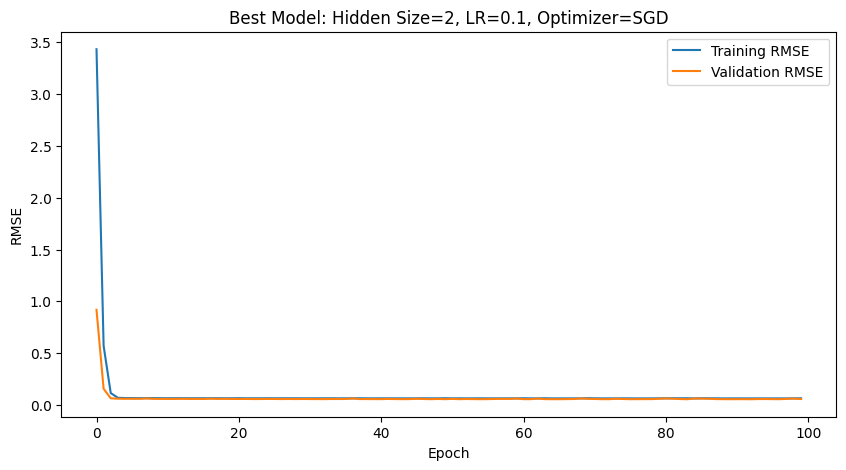

In [97]:
# Train final model with best hyperparameters
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

model = SimpleNN(input_size=X_train.shape[1], hidden_size=best_params['hidden_size'])
criterion = nn.MSELoss()
if best_params['optimizer'] == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=best_params['learning_rate'])
elif best_params['optimizer'] == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])
elif best_params['optimizer'] == 'Adadelta':
    optimizer = optim.Adadelta(model.parameters(), lr=best_params['learning_rate'])
elif best_params['optimizer'] == 'ASGD':
    optimizer = optim.ASGD(model.parameters(), lr=best_params['learning_rate'])
elif best_params['optimizer'] == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(), lr=best_params['learning_rate'])

train_rmse_list, val_rmse_list = train_model(model, optimizer, criterion, train_loader, val_loader, n_epochs=100)
plot_rmse(train_rmse_list, val_rmse_list, best_params)

In [98]:
# Evaluate on test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_rmse = np.sqrt(test_loss.item())

print(f'Test RMSE: {test_rmse}')

Test RMSE: 0.06749135756244516


# COMPLEX NN FOR 200 EPOCHS

In [99]:
class ComplexNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, dropout_prob=0.5):
        super(ComplexNN, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_size1)
        self.hidden2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
        self.output = nn.Linear(hidden_size2, 1)
    
    def forward(self, x):
        x = self.hidden1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.hidden2(x)
        x = self.relu(x)
        x = self.output(x)
        return x

# Training function
def train_model(model, optimizer, criterion, train_loader, val_loader=None, n_epochs=200):
    train_rmse_list = []
    val_rmse_list = []

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        
        train_rmse = np.sqrt(train_loss / len(train_loader.dataset))
        train_rmse_list.append(train_rmse)

        if val_loader is not None:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item() * inputs.size(0)
            
            val_rmse = np.sqrt(val_loss / len(val_loader.dataset))
            val_rmse_list.append(val_rmse)

        else:
            val_rmse_list.append(float('nan'))

    return train_rmse_list, val_rmse_list


# Hyperparameter search function
def hyperparameter_search(X_train, y_train, hidden_sizes, learning_rates, optimizers, n_folds=5):
    best_score = float('inf')
    best_params = None

    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    for hidden_size1 in hidden_sizes:
        for hidden_size2 in hidden_sizes:
            for lr in learning_rates:
                for optimizer_name in optimizers:
                    fold_scores = []
                    for train_index, val_index in kf.split(X_train):
                        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
                        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

                        train_dataset = torch.utils.data.TensorDataset(X_train_fold, y_train_fold)
                        val_dataset = torch.utils.data.TensorDataset(X_val_fold, y_val_fold)

                        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
                        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

                        model = ComplexNN(input_size=X_train.shape[1], hidden_size1=hidden_size1, hidden_size2=hidden_size2)
                        criterion = nn.MSELoss()
                        if optimizer_name == 'SGD':
                            optimizer = optim.SGD(model.parameters(), lr=lr)
                        elif optimizer_name == 'Adam':
                            optimizer = optim.Adam(model.parameters(), lr=lr)
                        elif optimizer_name == 'Adadelta':
                            optimizer = optim.Adadelta(model.parameters(), lr=lr)
                        elif optimizer_name == 'ASGD':
                            optimizer = optim.ASGD(model.parameters(), lr=lr)
                        elif optimizer_name == 'RMSprop':
                            optimizer = optim.RMSprop(model.parameters(), lr=lr)

                        train_rmse_list, val_rmse_list = train_model(model, optimizer, criterion, train_loader, val_loader, n_epochs=100)
                        fold_scores.append(val_rmse_list[-1])

                    avg_score = np.mean(fold_scores)
                    if avg_score < best_score:
                        best_score = avg_score
                        best_params = {
                            'hidden_size1': hidden_size1,
                            'hidden_size2': hidden_size2,
                            'learning_rate': lr,
                            'optimizer': optimizer_name,
                            'train_rmse_list': train_rmse_list,
                            'val_rmse_list': val_rmse_list
                        }

    return best_params, best_score, val_loader

# Plotting function
def plot_rmse(train_rmse_list, val_rmse_list, best_params):
    plt.figure(figsize=(10, 5))
    plt.plot(train_rmse_list, label='Training RMSE')
    plt.plot(val_rmse_list, label='Validation RMSE')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.title(f'Best Model: Hidden Size1={best_params["hidden_size1"]}, Hidden Size2={best_params["hidden_size2"]}, LR={best_params["learning_rate"]}, Optimizer={best_params["optimizer"]}')
    plt.legend()
    plt.show()

In [100]:
# Main Pipeline
hidden_sizes = [16, 32, 64, 128]
learning_rates = [0.0001, 0.001, 0.01, 0.1]
optimizers = ['SGD', 'Adam', 'Adadelta', 'ASGD', 'RMSprop']

best_params, best_score, val_loader = hyperparameter_search(X_train, y_train, hidden_sizes, learning_rates, optimizers)

print(f'Best Hyperparameters: {best_params}')
print(f'Best RMSE Score: {best_score}')

Best Hyperparameters: {'hidden_size1': 128, 'hidden_size2': 32, 'learning_rate': 0.1, 'optimizer': 'SGD', 'train_rmse_list': [3.1826314657951396, 1.5185765828953113, 0.6548750216670974, 0.5759451725126528, 0.37836961452577694, 0.3449062490901121, 0.2770413677647907, 0.2924535709401763, 0.22612018335749365, 0.23353010565195428, 0.20206338852337558, 0.21775119999119336, 0.1727328076051965, 0.2160187272638013, 0.18211960228818858, 0.15105607832696505, 0.15905043893835796, 0.14244552111971392, 0.13307482718733887, 0.14131235546112933, 0.118583173147346, 0.10741565704072553, 0.12265961690537655, 0.1146392584999444, 0.10810934108471093, 0.10573964603384445, 0.12395712299772331, 0.10135991685809344, 0.11413568083134586, 0.10480909955360809, 0.09978711236915337, 0.09333921649898756, 0.08999860165698971, 0.10142786489013007, 0.08696538851936697, 0.08965981716728645, 0.08975737122707599, 0.08632170892482073, 0.08964891865890585, 0.08009041975303961, 0.08471433049916985, 0.07391931018245114, 0.08

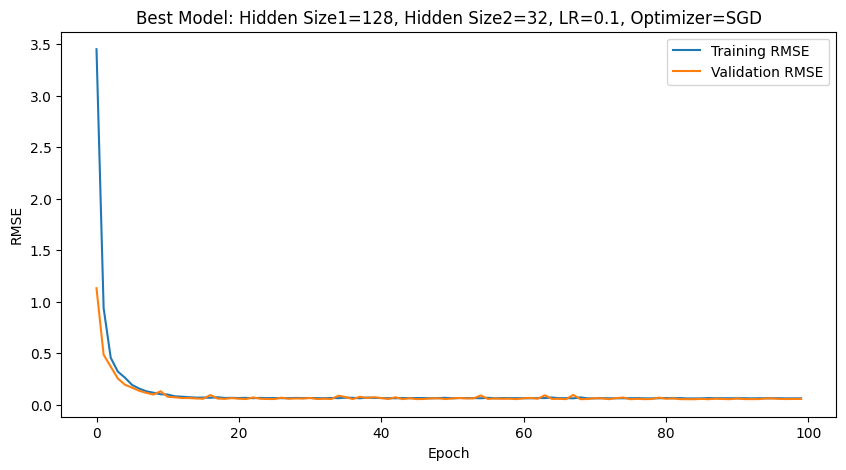

In [101]:
# Train final model with best hyperparameters and VAL_LOADER
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

model = ComplexNN(input_size=X_train.shape[1], hidden_size1=best_params['hidden_size1'], hidden_size2=best_params['hidden_size2'])
criterion = nn.MSELoss()
if best_params['optimizer'] == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=best_params['learning_rate'])
elif best_params['optimizer'] == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])
elif best_params['optimizer'] == 'Adadelta':
    optimizer = optim.Adadelta(model.parameters(), lr=best_params['learning_rate'])
elif best_params['optimizer'] == 'ASGD':
    optimizer = optim.ASGD(model.parameters(), lr=best_params['learning_rate'])
elif best_params['optimizer'] == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(), lr=best_params['learning_rate'])

train_rmse_list, val_rmse_list = train_model(model, optimizer, criterion, train_loader, val_loader, n_epochs=100)
plot_rmse(train_rmse_list, val_rmse_list, best_params)

In [102]:
# Evaluate on test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_rmse = np.sqrt(test_loss.item())

print(f'Test RMSE: {test_rmse}')

Test RMSE: 0.06565221976983861


# COMPLEX NN FOR 200 EPOCHS, WITHOUT DROPOUT

In [103]:
class ComplexNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(ComplexNN, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_size1)
        self.hidden2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_size2, 1)
    
    def forward(self, x):
        x = self.hidden1(x)
        x = self.relu(x)
        x = self.hidden2(x)
        x = self.relu(x)
        x = self.output(x)
        return x

# Training function
def train_model(model, optimizer, criterion, train_loader, val_loader=None, n_epochs=200):
    train_rmse_list = []
    val_rmse_list = []

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        
        train_rmse = np.sqrt(train_loss / len(train_loader.dataset))
        train_rmse_list.append(train_rmse)

        if val_loader is not None:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item() * inputs.size(0)
            
            val_rmse = np.sqrt(val_loss / len(val_loader.dataset))
            val_rmse_list.append(val_rmse)

        else:
            val_rmse_list.append(float('nan'))

    return train_rmse_list, val_rmse_list


# Hyperparameter search function
def hyperparameter_search(X_train, y_train, hidden_sizes, learning_rates, optimizers, n_folds=5):
    best_score = float('inf')
    best_params = None

    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    for hidden_size1 in hidden_sizes:
        for hidden_size2 in hidden_sizes:
            for lr in learning_rates:
                for optimizer_name in optimizers:
                    fold_scores = []
                    for train_index, val_index in kf.split(X_train):
                        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
                        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

                        train_dataset = torch.utils.data.TensorDataset(X_train_fold, y_train_fold)
                        val_dataset = torch.utils.data.TensorDataset(X_val_fold, y_val_fold)

                        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
                        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

                        model = ComplexNN(input_size=X_train.shape[1], hidden_size1=hidden_size1, hidden_size2=hidden_size2)
                        criterion = nn.MSELoss()
                        if optimizer_name == 'SGD':
                            optimizer = optim.SGD(model.parameters(), lr=lr)
                        elif optimizer_name == 'Adam':
                            optimizer = optim.Adam(model.parameters(), lr=lr)
                        elif optimizer_name == 'Adadelta':
                            optimizer = optim.Adadelta(model.parameters(), lr=lr)
                        elif optimizer_name == 'ASGD':
                            optimizer = optim.ASGD(model.parameters(), lr=lr)
                        elif optimizer_name == 'RMSprop':
                            optimizer = optim.RMSprop(model.parameters(), lr=lr)

                        train_rmse_list, val_rmse_list = train_model(model, optimizer, criterion, train_loader, val_loader, n_epochs=100)
                        fold_scores.append(val_rmse_list[-1])

                    avg_score = np.mean(fold_scores)
                    if avg_score < best_score:
                        best_score = avg_score
                        best_params = {
                            'hidden_size1': hidden_size1,
                            'hidden_size2': hidden_size2,
                            'learning_rate': lr,
                            'optimizer': optimizer_name,
                            'train_rmse_list': train_rmse_list,
                            'val_rmse_list': val_rmse_list
                        }

    return best_params, best_score, val_loader

# Plotting function
def plot_rmse(train_rmse_list, val_rmse_list, best_params):
    plt.figure(figsize=(10, 5))
    plt.plot(train_rmse_list, label='Training RMSE')
    plt.plot(val_rmse_list, label='Validation RMSE')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.title(f'Best Model: Hidden Size1={best_params["hidden_size1"]}, Hidden Size2={best_params["hidden_size2"]}, LR={best_params["learning_rate"]}, Optimizer={best_params["optimizer"]}')
    plt.legend()
    plt.show()

In [104]:
# Main Pipeline
hidden_sizes = [16, 32, 64, 128]
learning_rates = [0.0001, 0.001, 0.01, 0.1]
optimizers = ['SGD', 'Adam', 'Adadelta', 'ASGD', 'RMSprop']

best_params, best_score, val_loader = hyperparameter_search(X_train, y_train, hidden_sizes, learning_rates, optimizers)

print(f'Best Hyperparameters: {best_params}')
print(f'Best RMSE Score: {best_score}')

Best Hyperparameters: {'hidden_size1': 128, 'hidden_size2': 16, 'learning_rate': 0.1, 'optimizer': 'ASGD', 'train_rmse_list': [6.935491862793673, 1.6191565816229139, 0.3676783964437429, 0.18721478027358843, 0.20276251692315034, 0.14645306180527828, 0.10648949520321707, 0.11016084771400181, 0.11817605033705507, 0.08478410987686681, 0.07438723467115389, 0.08330905356816028, 0.11253473822255164, 0.07111830909020332, 0.08539042227116396, 0.07134702225408407, 0.06766035412111086, 0.07104028394336322, 0.06830702567159232, 0.06808473795756786, 0.06796877880341708, 0.07163918243498159, 0.06832119852139168, 0.06788982471162475, 0.06451335884691298, 0.06631186180408442, 0.06565012516126707, 0.06417600833186923, 0.0629665683978243, 0.06459537635136633, 0.06415859598305261, 0.06759259603016902, 0.06309451051125439, 0.06379767611578901, 0.07482606318261294, 0.06276603072255524, 0.06348041787377491, 0.06232979291346848, 0.06288841866942663, 0.061177208538795304, 0.06100185151617477, 0.06094351969833

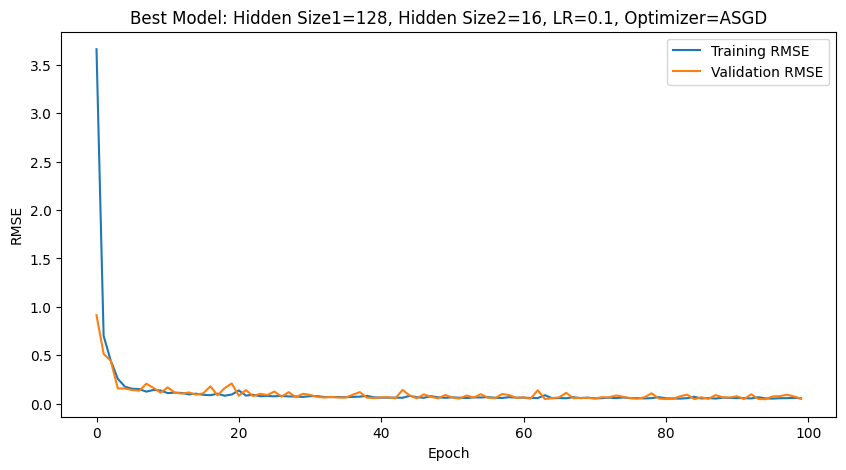

In [105]:
# Train final model with best hyperparameters and VAL_LOADER
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

model = ComplexNN(input_size=X_train.shape[1], hidden_size1=best_params['hidden_size1'], hidden_size2=best_params['hidden_size2'])
criterion = nn.MSELoss()
if best_params['optimizer'] == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=best_params['learning_rate'])
elif best_params['optimizer'] == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])
elif best_params['optimizer'] == 'Adadelta':
    optimizer = optim.Adadelta(model.parameters(), lr=best_params['learning_rate'])
elif best_params['optimizer'] == 'ASGD':
    optimizer = optim.ASGD(model.parameters(), lr=best_params['learning_rate'])
elif best_params['optimizer'] == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(), lr=best_params['learning_rate'])

train_rmse_list, val_rmse_list = train_model(model, optimizer, criterion, train_loader, val_loader, n_epochs=100)
plot_rmse(train_rmse_list, val_rmse_list, best_params)

In [106]:
# Evaluate on test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_rmse = np.sqrt(test_loss.item())

print(f'Test RMSE: {test_rmse}')

Test RMSE: 0.076109671258712
